In [55]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import glob
import pickle
from src.utils import get_cfg_from_from_ckpt_path
from sklearn.decomposition import PCA
import numpy as np

In [56]:
plt.style.use('ggplot')

In [57]:
n_components = 9

In [58]:
#model = f"latent_dim_{n_components}_pooling_1_None"
ckpt_path = glob.glob(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_ecs_0/latent_dim_{n_components}_pooling_1_None/None/**/*.ckpt",recursive=True)[-1]

#ckpt_path = glob.glob(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_3D/pred_1_var_0_ecs_100/latent_dim_{n_components}_num_layers_5_linear_True/None/**/*.ckpt",recursive=True)[0]

print(ckpt_path)

/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_ecs_0/latent_dim_9_pooling_1_None/None/2024-06-28_16-34/checkpoints/val_loss=0.00-epoch=117.ckpt


In [59]:
cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = True)

```yaml

datamodule:
  _target_: src.data.BaseDatamodule
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_da, ecs_da_path: '${paths.variables}',
    ssf_da_path: '${paths.sound}'}
  x_max: ${normalization.x_max}
  x_min: ${normalization.x_min}
dimensions: 2D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  loss_weight: {ecs_weight: 0, prediction_weight: 1, variation_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  norm_stat: {x_max: '${normalization.x_max}', x_min: '${normalization.x_min}'}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.01, weight_decay: 0.001}
model_architecture: AE_CNN_pool
model_config:
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  model_hparams:
    AE_CNN_2D:
      act_fn_str: Relu
      base_channels: 107
      batch_norm: false
      dropout_proba: 0.0
      dtype_str: float32
      latent_dim: 10
      num_layers: 4
      pooling_str: None
      spatial_dim: [107, 240, 240]
    AE_CNN_3D:
      act_fn_str: Relu
      base_channels: 1
      batch_norm: false
      dropout_proba: 0.0
      dtype_str: float32
      latent_dim: 10
      num_layers: 4
      pooling_str: None
      spatial_dim: [107, 240, 240]
    AE_CNN_pool_2D: {act_fn_str: None, dtype_str: float32, input_channels: 107, latent_dim: 9,
      num_layers: 1, pooling_str: None}
    ECS_explicit_pred_3D:
      depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
normalization: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc, variables: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc}
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: 10, verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: false,
    name: '${model.model_name}/pred_${model.loss_weight.prediction_weight}_var_${model.loss_weight.variation_weight}_ecs_${model.loss_weight.ecs_weight}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/AE_V2/",
    version: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 1000
  min_epochs: 0


```

In [60]:
cmap = plt.get_cmap('viridis')

In [61]:
gpu = 2
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [62]:
t, lat, lon = 30, 173, 0

In [63]:
x_min = 1459.0439165829073
x_max = 1545.8698054910844

In [64]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [65]:
def explicit_ecs(ssp: torch.tensor,
                 depth_tens: torch.tensor,
                 tau = 100):
    ssp = ssp.unsqueeze(1).nan_to_num()          
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    
        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    return ecs_pred

In [66]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="fit") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api
dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api


In [67]:
depth_array = dm.train_dataloader().dataset.input.z.data

In [68]:
coords = dm.train_dataloader().dataset.input.coords

In [69]:
train_ssp_ds = dm.train_dataloader().dataset.input
#train_ssp_ds_drop_na = train_ssp_ds.dropna(dim='lat')
train_ssp_arr = train_ssp_ds.data
train_ssp_tens = torch.tensor(train_ssp_arr).float().to(device)
input_train_shape = train_ssp_arr.shape

test_ssp_ds = dm.test_dataloader().dataset.input
#test_ssp_ds_drop_na = test_ssp_ds.dropna(dim='lat')
test_ssp_arr = test_ssp_ds.data
test_ssp_tens = torch.tensor(test_ssp_arr).float().to(device)
input_test_shape = test_ssp_arr.shape

del train_ssp_ds
del test_ssp_ds

In [70]:
lit_model = load_model(ckpt_path, device)
ssp_pred = lit_model(test_ssp_tens)

In [71]:
ecs_truth = explicit_ecs(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float())
ecs_pred_ae = explicit_ecs(ssp_pred.float(),torch.tensor(depth_array).float())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


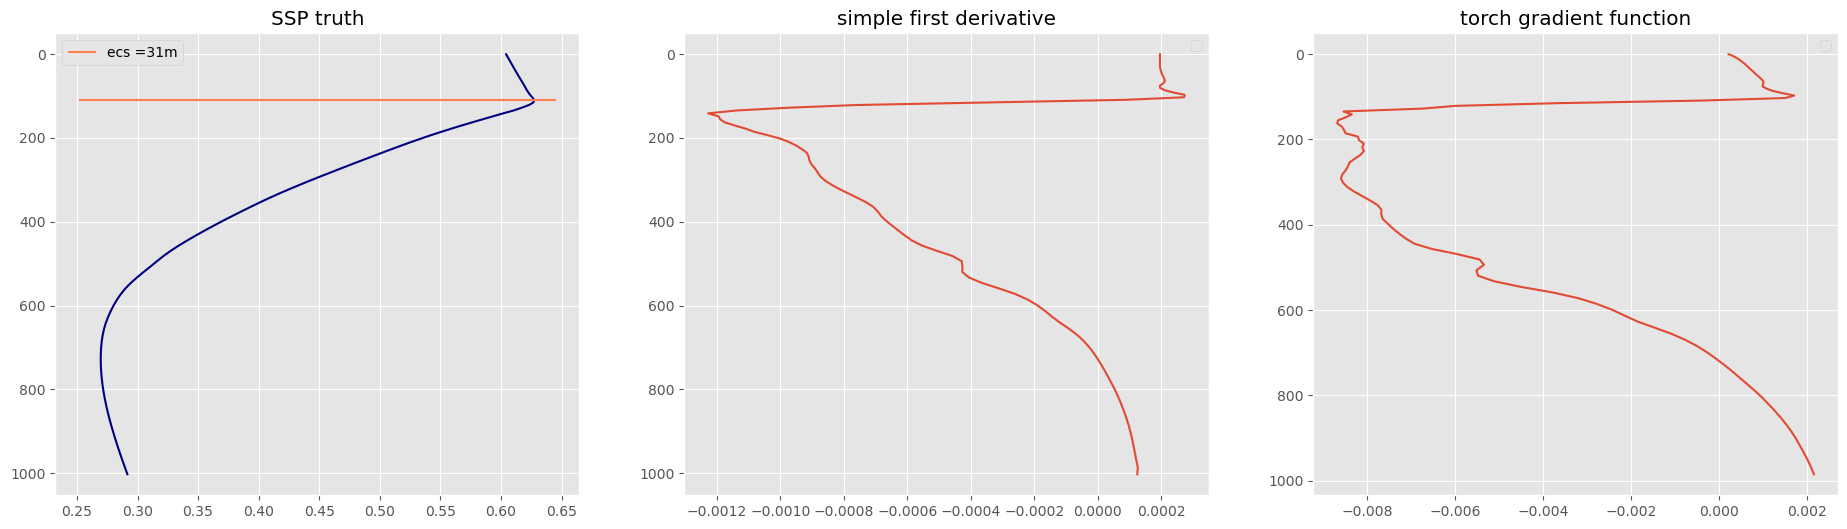

In [72]:
fig,axs = plt.subplots(1,3,figsize=(23,6))
axs[0].plot(test_ssp_tens[t,:,lat,lon].detach().cpu(), depth_array, c = "navy", label = "")  
axs[0].set_title("SSP truth")
#axs[1].plot(np.divide(test_ssp_tens[t,1:,lat,lon].detach().cpu() - test_ssp_tens[t,:-1,lat,lon].detach().cpu().numpy(), depth_array[1:] - depth_array[:-1]),depth_array[:-1])
#first_derivative = torch.zeros(len(depth_array))
first_derivative = np.array([(test_ssp_tens[t,i+1,lat,lon].detach().cpu() - test_ssp_tens[t,i-1,lat,lon].detach().cpu())/(depth_array[i+1]-depth_array[i-1]) for i in range (1,len(depth_array)-1)])
first_derivative = np.insert(first_derivative, 0, (test_ssp_tens[t,1,lat,lon].detach().cpu() - test_ssp_tens[t,0,lat,lon].detach().cpu())/(depth_array[1]-depth_array[0]))
first_derivative = np.insert(first_derivative, -1, (test_ssp_tens[t,-1,lat,lon].detach().cpu() - test_ssp_tens[t,-2,lat,lon].detach().cpu())/(depth_array[-1]-depth_array[-2]))
axs[1].plot(first_derivative,depth_array)
axs[1].set_title("simple first derivative")


variation = test_ssp_tens[t,1:,lat,lon].detach().cpu() - test_ssp_tens[t,:-1,lat,lon].detach().cpu()

axs[2].plot(variation.cpu(),depth_array[:-1]) 
axs[2].set_title("torch gradient function")


xmin, xmax = axs[0].get_xlim()
axs[0].hlines(depth_array[np.argmax(test_ssp_tens[t,:,lat,lon].detach().cpu().numpy())], xmin=xmin, xmax=xmax, label = f"ecs ={int(np.argmax(test_ssp_tens[t,:,lat,lon].detach().cpu().numpy()))}m", colors = "coral")

for ax in axs[:]:
    ax.legend()
    ax.invert_yaxis() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


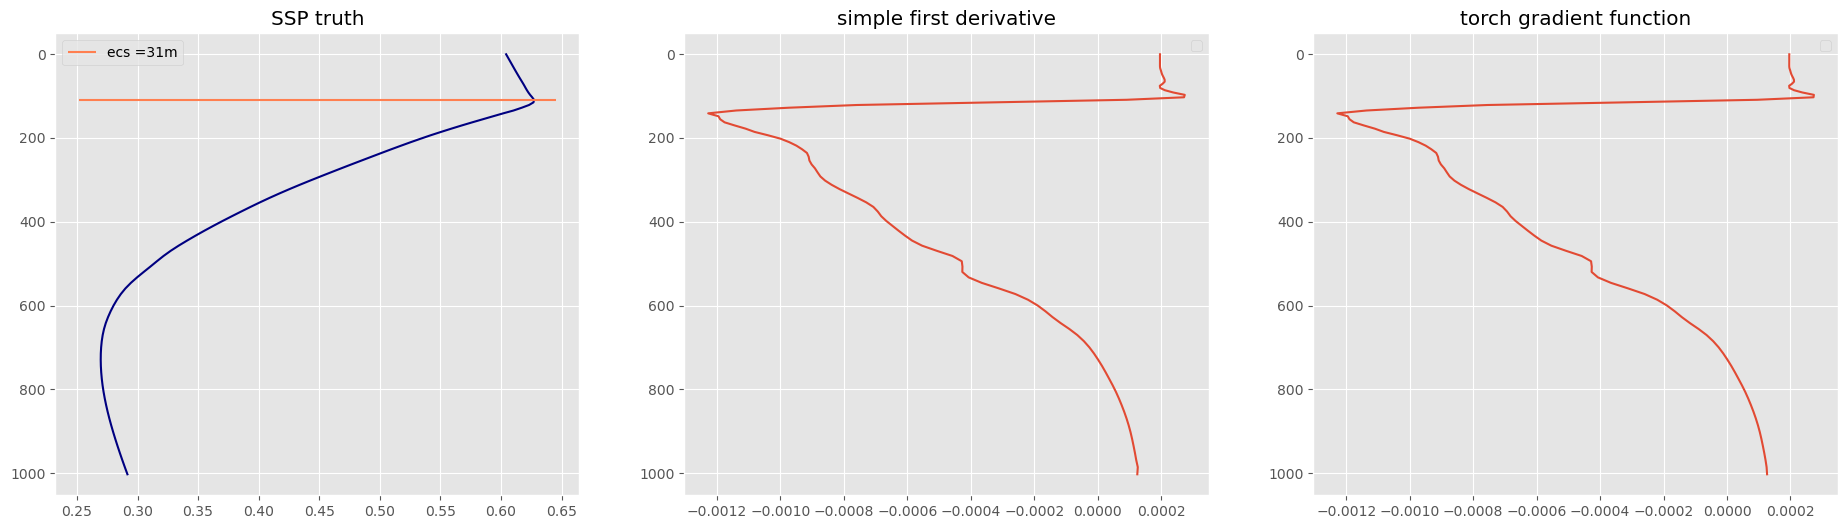

In [73]:
fig,axs = plt.subplots(1,3,figsize=(23,6))
axs[0].plot(test_ssp_tens[t,:,lat,lon].detach().cpu(), depth_array, c = "navy", label = "")  
axs[0].set_title("SSP truth")
#axs[1].plot(np.divide(test_ssp_tens[t,1:,lat,lon].detach().cpu() - test_ssp_tens[t,:-1,lat,lon].detach().cpu().numpy(), depth_array[1:] - depth_array[:-1]),depth_array[:-1])
#first_derivative = torch.zeros(len(depth_array))
first_derivative = np.array([(test_ssp_tens[t,i+1,lat,lon].detach().cpu() - test_ssp_tens[t,i-1,lat,lon].detach().cpu())/(depth_array[i+1]-depth_array[i-1]) for i in range (1,len(depth_array)-1)])
first_derivative = np.insert(first_derivative, 0, (test_ssp_tens[t,1,lat,lon].detach().cpu() - test_ssp_tens[t,0,lat,lon].detach().cpu())/(depth_array[1]-depth_array[0]))
first_derivative = np.insert(first_derivative, -1, (test_ssp_tens[t,-1,lat,lon].detach().cpu() - test_ssp_tens[t,-2,lat,lon].detach().cpu())/(depth_array[-1]-depth_array[-2]))
axs[1].plot(first_derivative,depth_array)
axs[1].set_title("simple first derivative")


coordinates = (torch.tensor(depth_array).to(device),)
gradient = torch.gradient(input = test_ssp_tens[t,:,lat,lon], spacing = coordinates)[0]
# second_derivative = np.array([(test_ssp_tens[t,i+1,lat,lon].detach().cpu() - 2*test_ssp_tens[t,i,lat,lon].detach().cpu() + test_ssp_tens[t,i-1,lat,lon].detach().cpu())/(((depth_array[i+1]-depth_array[i-1])/2)**2) for i in range (1,len(depth_array)-1)])
axs[2].plot(gradient.cpu(),depth_array) 
axs[2].set_title("torch gradient function")


xmin, xmax = axs[0].get_xlim()
axs[0].hlines(depth_array[np.argmax(test_ssp_tens[t,:,lat,lon].detach().cpu().numpy())], xmin=xmin, xmax=xmax, label = f"ecs ={int(np.argmax(test_ssp_tens[t,:,lat,lon].detach().cpu().numpy()))}m", colors = "coral")

for ax in axs[:]:
    ax.legend()
    ax.invert_yaxis() 

In [74]:
gradient

tensor([ 1.9622e-04,  1.9620e-04,  1.9617e-04,  1.9617e-04,  1.9616e-04,
         1.9616e-04,  1.9618e-04,  1.9622e-04,  1.9622e-04,  1.9620e-04,
         1.9618e-04,  1.9615e-04,  1.9614e-04,  1.9615e-04,  1.9623e-04,
         1.9677e-04,  1.9809e-04,  1.9964e-04,  2.0103e-04,  2.0278e-04,
         2.0537e-04,  2.0833e-04,  2.1089e-04,  2.1103e-04,  2.0480e-04,
         1.9576e-04,  1.9672e-04,  2.1108e-04,  2.3746e-04,  2.7375e-04,
         2.7254e-04,  9.5413e-05, -3.2211e-04, -7.5458e-04, -9.7209e-04,
        -1.1359e-03, -1.2281e-03, -1.1951e-03, -1.1896e-03, -1.1761e-03,
        -1.1444e-03, -1.1099e-03, -1.0814e-03, -1.0399e-03, -1.0001e-03,
        -9.7245e-04, -9.4945e-04, -9.3168e-04, -9.1629e-04, -9.1080e-04,
        -9.0845e-04, -9.0162e-04, -8.9102e-04, -8.8282e-04, -8.7396e-04,
        -8.5908e-04, -8.3839e-04, -8.1358e-04, -7.8561e-04, -7.5690e-04,
        -7.2943e-04, -7.0698e-04, -6.9308e-04, -6.8211e-04, -6.6625e-04,
        -6.4715e-04, -6.2777e-04, -6.0737e-04, -5.8

In [75]:
torch.gradient(input = test_ssp_tens, spacing = coordinates, dim=1)[0][t,:,lat,lon]

tensor([ 1.9622e-04,  1.9620e-04,  1.9617e-04,  1.9617e-04,  1.9616e-04,
         1.9616e-04,  1.9618e-04,  1.9622e-04,  1.9622e-04,  1.9620e-04,
         1.9618e-04,  1.9615e-04,  1.9614e-04,  1.9615e-04,  1.9623e-04,
         1.9677e-04,  1.9809e-04,  1.9964e-04,  2.0103e-04,  2.0278e-04,
         2.0537e-04,  2.0833e-04,  2.1089e-04,  2.1103e-04,  2.0480e-04,
         1.9576e-04,  1.9672e-04,  2.1108e-04,  2.3746e-04,  2.7375e-04,
         2.7254e-04,  9.5413e-05, -3.2211e-04, -7.5458e-04, -9.7209e-04,
        -1.1359e-03, -1.2281e-03, -1.1951e-03, -1.1896e-03, -1.1761e-03,
        -1.1444e-03, -1.1099e-03, -1.0814e-03, -1.0399e-03, -1.0001e-03,
        -9.7245e-04, -9.4945e-04, -9.3168e-04, -9.1629e-04, -9.1080e-04,
        -9.0845e-04, -9.0162e-04, -8.9102e-04, -8.8282e-04, -8.7396e-04,
        -8.5908e-04, -8.3839e-04, -8.1358e-04, -7.8561e-04, -7.5690e-04,
        -7.2943e-04, -7.0698e-04, -6.9308e-04, -6.8211e-04, -6.6625e-04,
        -6.4715e-04, -6.2777e-04, -6.0737e-04, -5.8

In [77]:
mse_pred = (lit_model(train_ssp_tens) - train_ssp_tens)**2


ssp_gradient_truth = torch.gradient(input = train_ssp_tens, spacing = coordinates, dim=1)[0]
ssp_gradient_pred = torch.gradient(input = lit_model(train_ssp_tens), spacing = coordinates, dim=1)[0]

gradient_loss =  (ssp_gradient_truth - ssp_gradient_pred)**2   

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.54 GiB. GPU 2 has a total capacity of 79.14 GiB of which 316.12 MiB is free. Process 284439 has 16.36 GiB memory in use. Process 758663 has 13.78 GiB memory in use. Including non-PyTorch memory, this process has 48.65 GiB memory in use. Of the allocated memory 46.41 GiB is allocated by PyTorch, and 1.75 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)